In [3]:
import copy
from pathlib import Path
import warnings
import os

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
%matplotlib inline

In [24]:
class Singleton(type):
    _instances = {}
    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]
        
class Logger(metaclass=Singleton):
    def __init__(self):
        self.a = 10

x = Logger()

In [27]:
y = Logger()
y.a

21

In [12]:
df = pd.read_csv('C:/Users/User/PycharmProjects/crypto/data/Binance_BTCUSDT_1h.csv', parse_dates=['date'])
df = df[df.date > "2018-01-01"]
for f in os.listdir('C:/Users/User/PycharmProjects/crypto/data/'):
    tmp = pd.read_csv('C:/Users/User/PycharmProjects/crypto/data/'+f, parse_dates=['date'])
    tmp = tmp.set_index('date').loc[df.date.values]
    df[f[8:11]] = tmp.open.values
    df[f[8:11]+'_relative'] = ((tmp.close - tmp.open)/tmp.open.values*100).values
#df = pd.concat(df)
df = df[df.index%4 == 0]
df["time_idx"] = range(df.shape[0],0, -1)
df = df.sort_values('time_idx')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,BTC,BTC_relative,ETH,ETH_relative,LTC,LTC_relative,time_idx
34268,1.514768e+09,2018-01-01 01-AM,BTC/USDT,13529.01,13595.89,13155.38,13203.06,359.65,4832291.65,NaN,13529.01,-2.409267,727.62,-1.326242,219.98,-3.286662,1
34264,1.514783e+09,2018-01-01 05-AM,BTC/USDT,13601.01,13699.00,13526.50,13558.99,383.17,5212466.36,NaN,13601.01,-0.308948,744.82,0.559867,223.95,0.111632,2
34260,1.514797e+09,2018-01-01 09-AM,BTC/USDT,13499.99,13670.00,13459.11,13616.99,204.89,2781963.86,NaN,13499.99,0.866667,745.00,1.102013,224.50,1.118040,3
34256,1.514812e+09,2018-01-01 01-PM,BTC/USDT,13172.42,13200.41,12815.70,13017.00,434.09,5638438.57,NaN,13172.42,-1.179889,745.00,-0.814765,222.33,-1.497774,4
34252,1.514826e+09,2018-01-01 05-PM,BTC/USDT,13018.00,13198.98,13000.00,13022.00,220.62,2889269.65,NaN,13018.00,0.030727,739.08,-0.278725,220.00,-0.227273,5


In [4]:
# if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.
batch_size, time_steps, input_dim = 64, 763, 1

tcn_layer = TCN(kernel_size=4, dilations=(1, 2, 4, 8, 16, 32, 64),dropout_rate=0.3,
            use_skip_connections=True,
            use_layer_norm=True)
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
    tcn_layer,
    Dense(1),
])

m.compile(optimizer='adam', loss='mse')


Receptive field size = 763


In [56]:
def get_x_y(values):
    size = len(values)-time_steps
    x = np.zeros((size, time_steps))
    y = np.zeros((size,1))
    for i in range(size):
        x[i] = values[i:i+time_steps]
        y[i] = values[i+time_steps]
    return np.expand_dims(x,2),y

x,y = get_x_y(df.open.values[:30000+time_steps])
x_test, y_test = get_x_y(df.open.values[30000:])
#train_dataset = Dataset.from_tensor_slices((x, y)).shuffle(1000)
#test_dataset = Dataset.from_tensor_slices((x_test, y_test))
m.fit(x,y, epochs=10, validation_data=(x_test,y_test), batch_size=64)

In [13]:
# define dataset
max_encoder_length = 50
max_prediction_length = 3
training_cutoff = "2021-05-01"  # day for cutoff

training = TimeSeriesDataSet(
    df[df.date < training_cutoff],
    time_idx='time_idx',
    target='BTC_relative',
    min_prediction_idx=0,
    # weight="weight",
    group_ids=['symbol'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['BTC_relative', 'ETH_relative', 'LTC_relative', 'Volume BTC'],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
)


In [14]:

# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=6)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=6)


In [16]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=1e-3,
    hidden_size=128,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=3,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 1004.8k


C:\Users\User\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:819: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 768   
4  | static_variable_selection          | VariableSelectionNetwork        | 25.7 K
5  | encoder_variable_

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_MAE': 0.813874363899231,
 'val_MAPE': 65933.8984375,
 'val_RMSE': 1.1120615005493164,
 'val_SMAPE': 1.4277963638305664,
 'val_loss': 0.2374141663312912}
--------------------------------------------------------------------------------


Restoring states from the checkpoint file at C:\Users\User\PycharmProjects\crypto\lr_find_temp_model.ckpt
Restored all states from the checkpoint file at C:\Users\User\PycharmProjects\crypto\lr_find_temp_model.ckpt


suggested learning rate: 0.0060255958607435805


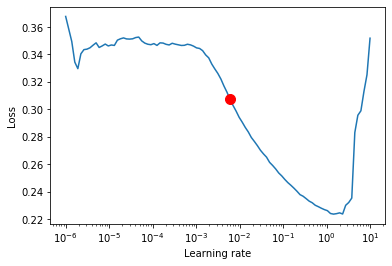

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


In [17]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [18]:
np.abs(validation.data['target'][0][3:]-validation.data['target'][0][:-3]).mean()

tensor(1.1280)

In [19]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=4, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=1e-3,
    hidden_size=128,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [20]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

C:\Users\User\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:532: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 768   
4  | static_variable_selection          | VariableSelectionNetwork        | 25.7 K
5  | encoder_variable_sel

Global seed set to 42


In [21]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(nan)

In [22]:
predictions

tensor([[54319.1836, 54310.5312, 54339.2852, 54385.9453, 54445.4688, 54514.8828],
        [54563.7734, 54570.5391, 54604.8984, 54653.8711, 54715.2539, 54786.5781],
        [54315.3477, 54322.5508, 54361.5742, 54415.4648, 54480.1641, 54553.2109],
        ...,
        [54319.1836, 54310.5312, 54339.2852,        nan,        nan,        nan],
        [54319.1836, 54310.5312, 54339.2852, 54385.9453,        nan,        nan],
        [54319.1836, 54310.5312, 54339.2852, 54385.9453, 54445.4688,        nan]])

In [29]:
actuals

tensor([[54801.3281, 54469.9609, 54846.2305, 54720.0703, 54567.6797, 54575.9297],
        [54469.9609, 54846.2305, 54720.0703, 54567.6797, 54575.9297, 54265.1016],
        [54846.2305, 54720.0703, 54567.6797, 54575.9297, 54265.1016, 53564.9414],
        ...,
        [54801.3281, 54469.9609, 54846.2305,     0.0000,     0.0000,     0.0000],
        [54801.3281, 54469.9609, 54846.2305, 54720.0703,     0.0000,     0.0000],
        [54801.3281, 54469.9609, 54846.2305, 54720.0703, 54567.6797,     0.0000]])

In [22]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

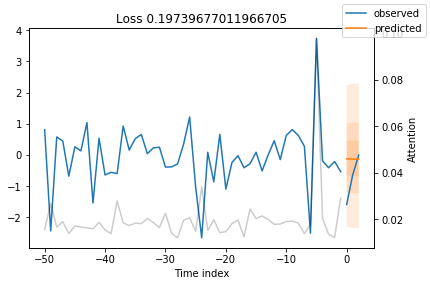

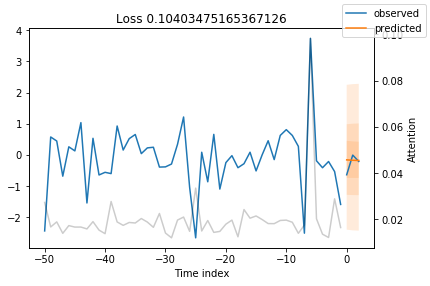

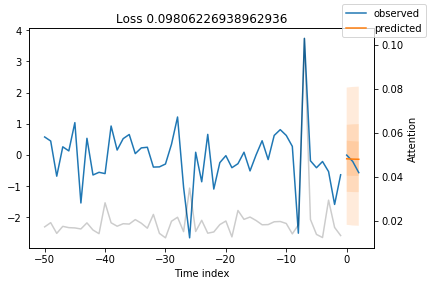

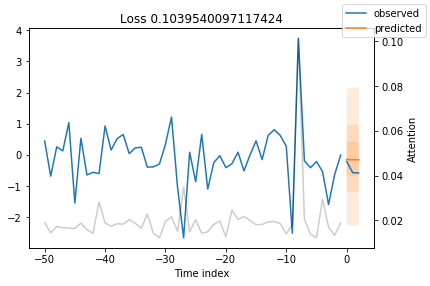

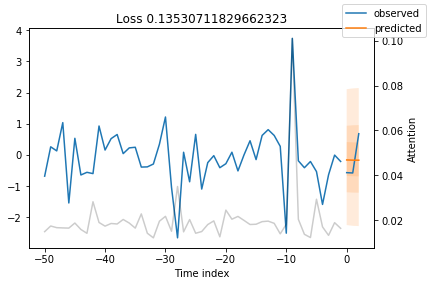

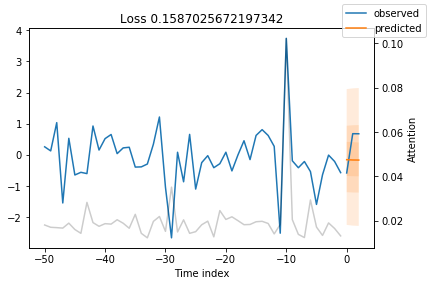

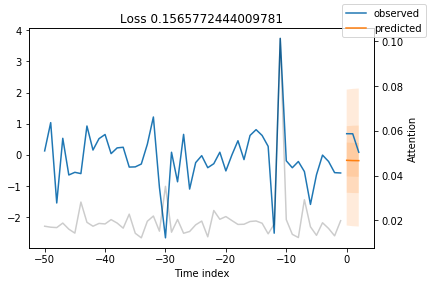

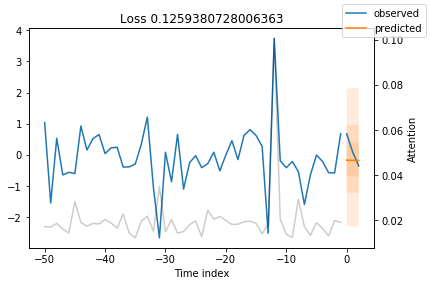

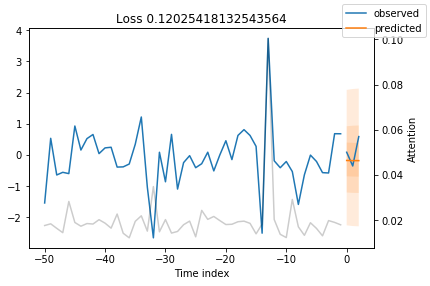

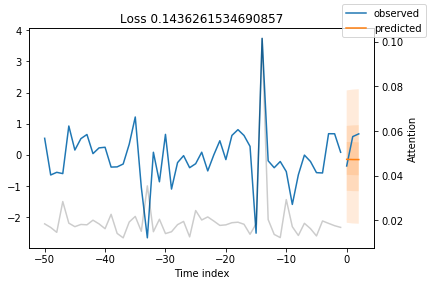

In [23]:
for idx in range(10):  # plot 10 examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);